# Magic BERT
#### Investigating the similarity of MtG flavor text with a large language model

We will be using the [Sentence-BERT](https://arxiv.org/abs/1908.10084) (SBERT) model, which has been pretrained and optimized for finding similarities in text. It is designed to provide meaningful embeddings of sentences such that outputs with low cosine distance will have very similar semantic content. To do so we will create a sentence-transformer using the [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) model, which according to the experts at [SBERT](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models) has the highest performance on these types of tasks.

---

This notebook is based off of the [NLP Course](https://huggingface.co/learn/nlp-course/en) from HuggingFace and [this Geeks for Geeks post](https://www.geeksforgeeks.org/sentence-similarity-using-bert-transformer/).


In [1]:
import numpy as np
import torch

# Create Model Object
from sentence_transformers import SentenceTransformer
# device = torch.device("mps")
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

/opt/miniconda3/envs/mtg_flavor/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's make up some flavor text! We will then run it through our model to see which are the most similar. 
Here I am writing two sentences about goblins and their odor, which should have a high similarity metric. The other two sentences are meant to sound like generic flavor text from Blue or Black cards, and should be dissimilar to each other and the two lines about Goblins. 

In [28]:
my_flavor_text = ["Goblins sure do smell bad.",
    "Those goblins are loud and offensive!",
    "The mind is the purest distillation of progress.",
    "My power over death makes me unstoppable"]

In [29]:
# By default the model uses Cosine Similarity as the similarity metric.
embeddings = model.encode(my_flavor_text)
similarities = model.similarity(embeddings,embeddings)
print(similarities)

tensor([[ 1.0000,  0.6725,  0.0113,  0.0721],
        [ 0.6725,  1.0000, -0.0032,  0.1065],
        [ 0.0113, -0.0032,  1.0000,  0.2725],
        [ 0.0721,  0.1065,  0.2725,  1.0000]])


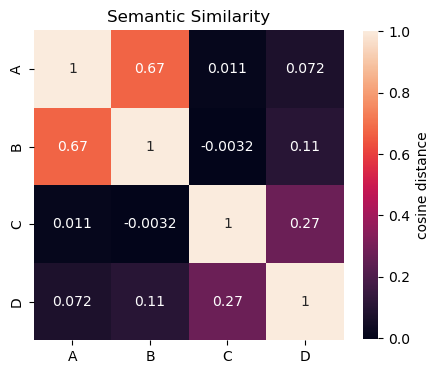

In [30]:
# Next we can visualize the similarities with a heat map matrix using Seaborn
import seaborn as sns
from matplotlib import pyplot as plt

labels = ['A','B','C','D']
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(similarities, annot=True,
            xticklabels=labels,yticklabels=labels,
            square=True,cbar_kws={'shrink':0.8,'label':'cosine distance'})
plt.title('Semantic Similarity')
plt.show(block=False)

As expected, the first two lines of text are very similar to eachother, while the remaining two are relatively dissimilar.

## Now, let's take a look at actual flavor text! 

Our hypothesis is that red cards will be most similar to other red cards, blue cards similar to other blue cards, and so forth.
To reduce computation time and simplify visualization, we will start with 500 cards: 100 monocolored cards from each of the five colors. 

In [37]:
# Load card data
import pickle
import pandas as pd
datapath = 'card_data/CardData.pkl'
with open(datapath,'rb') as file:    
    data = pickle.load(file)

# Simplify dataframe to relevant information
data = data.loc[:,['name','type_line','set','mana_cost','colors','flavor_text']].reset_index(drop=True)

# Identify monocolored cards
is_monocolored = data['colors'].apply(lambda x : np.shape(x) == (1,))
data['monocolored'] = is_monocolored

In [38]:
# Subset 100 random monocolored cards from each color
# Set a random seed for replicability:
np.random.seed(31)
colors = ['W','U','B','R','G']
mono_cards = data.loc[data['monocolored'],:]

card_subsample = pd.concat([mono_cards.loc[mono_cards['colors'].explode() == color,:].sample(100) for color in colors])
card_subsample = card_subsample.reset_index(drop=True)
print('Some example monocolored cards')
card_subsample.sample(10)

Some example monocolored cards


,name,type_line,set,mana_cost,colors,flavor_text,monocolored
320,Nyxborn Brute,Enchantment Creature — Cyclops,thb,{3}{R}{R},[R],"""one-eyed and frightful, the cyclops\nlifted a...",True
171,Treasure Hunt,Sorcery,c18,{1}{U},[U],"""the longer the journey, the more one learns.""...",True
149,Strategic Planning,Sorcery,khm,{1}{U},[U],alrund sees the future as a whorl of signs and...,True
363,Goblin,Token Creature — Goblin,p03,,[R],never underestimate the power of overwhelming ...,True
6,Aerial Maneuver,Instant,gtc,{1}{W},[W],"""when you put all of yourself into an attack, ...",True
353,Bloodpyre Elemental,Creature — Elemental,ala,{4}{R},[R],elementals born of jund are as cruel and unsta...,True
70,Charging Griffin,Creature — Griffin,m14,{3}{W},[W],"four claws, two wings, one beak, no fear.",True
275,Morbid Opportunist,Creature — Human Rogue,spg,{2}{B},[B],"""it's downright selfish to die with full pocke...",True
392,Ancient Grudge,Instant,mm3,{1}{R},[R],"if there's anything a werewolf hates, it's a c...",True
230,Gruesome Realization,Sorcery,bro,{1}{B}{B},[B],mishra was gone—all that remained was a machin...,True


In [39]:
# Extract the flavor text column from our data frame and run it through our model
flavor_text_sample = card_subsample['flavor_text'].to_numpy()
embeddings = model.encode(flavor_text_sample)
similarities = model.similarity(embeddings,embeddings)


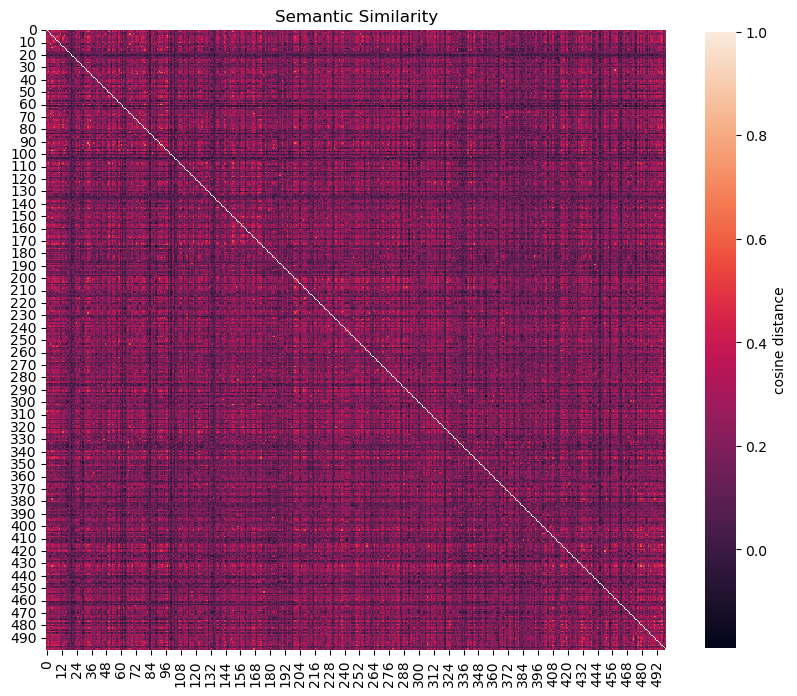

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(similarities, annot=False,
            square=True,cbar_kws={'shrink':0.8,'label':'cosine distance'})
plt.title('Semantic Similarity')
plt.show(block=False)

Despite putting the flavor text in order of color, there doesn't seem to be any underlying structure. 

Let's take a closer look at which cards are most and least similar

In [41]:
sim_np = similarities.numpy() # from tensor to np array
np.fill_diagonal(sim_np,0)
# Fill the upper triangle of the matrix with zeros so we don't get repeated pairs
sim_np = np.tril(sim_np)

In [42]:
# Look for the top 10 most similar pairs of text:
# Unravel similarities
sim_np_unravel = sim_np.reshape(-1)
x,y = np.unravel_index(np.argpartition(sim_np_unravel,-10),sim_np.shape)
# each x-y pair corresponds to a pair of flavor texts. 
# Iterate through them and print out each pair along with their similarity scores
# (Note that the scores are unsorted, but last 10 are guaranteed to be the top 10 highest scores)
x_top = x[-10:]
y_top = y[-10:]
for i in range(len(x_top)):
    sim_score = float(sim_np[x_top[i]][y_top[i]])
    print(f"Similarity Score = {np.round(sim_score,3)}")
    print(card_subsample['name'][x_top[i]])
    print("   ",flavor_text_sample[x_top[i]])
    print("")
    print(card_subsample['name'][y_top[i]])
    print("   ",flavor_text_sample[y_top[i]])
    print(" ")
    print('--------')

Similarity Score = 0.65
Witness of Tomorrows
    "as the future slips its way into the present, it ceases to be my concern."

Tempest of Light
    "let everything return to its true nature, so that destiny may take its course."
 
--------
Similarity Score = 0.654
Norwood Warrior
    "the woods hold peace for those who desire it, but those who seek battle will find me."

Nylea's Intervention
    "i bring a wilderness no law can tame."
 
--------
Similarity Score = 0.665
Earthcraft
    "the land gives up little, but we are masters of persuasion."
—eladamri, lord of leaves

Skyshroud Troopers
    "we were not made for war. like flowstone, volrath shaped us to it."
—eladamri, lord of leaves
 
--------
Similarity Score = 0.657
Zendikar's Roil
    "i was wrong. zendikar isn't after me. it isn't after any of us. it's not evil or vengeful. it's magnificent . . . but it's in pain."
—nissa revane

Turntimber Sower
    "zendikar's wounds can be healed."
 
--------
Similarity Score = 0.661
Darknes

These seem to mesh relatively well with eachother. Now let's take a look at the lowest scores and see if they look wildly different:

In [43]:
# First replace all 0's with 1's so that we can still ignore the diagonal and upper triangle
sim_np[sim_np == 0] = 1
x,y = np.unravel_index(np.argpartition(sim_np_unravel,5),sim_np.shape)
sim_np_unravel = sim_np.reshape(-1)
x_top = x[:5]
y_top = y[:5]
for i in range(len(x_top)):
    sim_score = float(sim_np[x_top[i]][y_top[i]])
    print(f"Similarity Score = {np.round(sim_score,3)}")
    print(card_subsample['name'][x_top[i]])
    print("   ",flavor_text_sample[x_top[i]])
    print("")
    print(card_subsample['name'][y_top[i]])
    print("   ",flavor_text_sample[y_top[i]])
    print(" ")
    print('--------')

Similarity Score = -0.19
Scroll Thief
    the arcane academies along the coast were powerless to protect themselves from the brazen raiders of the kapsho seas.

Cephalid Facetaker
    few think to look past a familiar face and a friendly smile.
 
--------
Similarity Score = -0.175
Apothecary Stomper
    a walking clinic with a trumpet to sound its arrival.

Scroll Thief
    the arcane academies along the coast were powerless to protect themselves from the brazen raiders of the kapsho seas.
 
--------
Similarity Score = -0.171
Kiki-Jiki, Mirror Breaker
    "wanna see a neat trick?"

Carrion Feeder
    it has no respect for the deeds of martyrs, reducing their legacy to a mouthful of flesh.
 
--------
Similarity Score = -0.156
Moldgraf Millipede
    between stitchers, cultists, and scavengers, corpses are in high demand.

You're Confronted by Robbers
    their only mistake was giving the bard time to speak.
 
--------
Similarity Score = -0.152
Most Valuable Slayer
    torain had never lo

While it is difficult to say if these pairs are truly *disparate* in some way, they certainly different vibes than those flavor text pairs that are most similar.

### Comparing cards by their relationship to all cards in a color

From our previous matrix, it is difficult to say how similar cards within a color are to eachother compared to other colors. Here we will measure that explicitly by taking the average similarity of each card to each other card, broken down by color.

In [44]:
# Reset the similarity matrix so we no longer ignore the upper triangle:
sim_np = similarities.numpy() # from tensor to np array
color_vect = card_subsample.colors.to_numpy()

for i in card_subsample.index:
    for c in colors:
        color_inds = card_subsample.loc[card_subsample.colors.explode() == c,:].index
        color_inds = color_inds[color_inds != i]
        color_similarities = sim_np[i,color_inds]
        color_sim_mean = np.mean(color_similarities)
        column_name = c[0]+"_mean_similarity"
        card_subsample.loc[i,column_name] = color_sim_mean

In [45]:
card_subsample.sample(10)

,name,type_line,set,mana_cost,colors,flavor_text,monocolored,W_mean_similarity,U_mean_similarity,B_mean_similarity,R_mean_similarity,G_mean_similarity
374,Blasphemous Act,Sorcery,ltc,{8}{R},[R],"""and there are some things, of course, whose s...",True,0.241952,0.231887,0.264270,0.250579,0.279235
430,Prismatic Omen,Enchantment,shm,{1}{G},[G],"in times of portent, the land sculpts itself i...",True,0.205981,0.204982,0.204910,0.179833,0.239606
24,"Senu, Keen-Eyed Protector",Legendary Creature — Bird Scout,acr,{1}{W},[W],"""be my eyes, senu!""\n—bayek of siwa",True,0.255525,0.234961,0.244157,0.209461,0.213273
213,Highborn Vampire,Creature — Vampire Warrior,znr,{3}{B},[B],with the bloodchiefs annihilated in the fight ...,True,0.143666,0.134823,0.192683,0.162721,0.186678
266,Black Carriage,Creature — Horse,hml,{3}{B}{B},[B],"""the baron's drivers are also driven.""\n—chandler",True,0.168504,0.148611,0.158482,0.152692,0.148611
72,Dromad Purebred,Creature — Camel Beast,rav,{4}{W},[W],"""i have seen much from the back of my dromad, ...",True,0.261756,0.232377,0.231769,0.203290,0.240313
290,Agonizing Remorse,Sorcery,sta,{1}{B},[B],"""guilt is not absolution. regret is not justic...",True,0.225294,0.198240,0.234181,0.190827,0.190738
418,Ice Storm,Sorcery,sld,{2}{G},[G],nothing could survive in the wake of storm's b...,True,0.101484,0.119335,0.146261,0.144531,0.146739
105,Trickster's Talisman,Artifact — Equipment,afr,{U},[U],"""lady luck, smile on me!""",True,0.149876,0.129971,0.137964,0.109750,0.110411
446,Mulch,Sorcery,tpr,{1}{G},[G],hope is the one crop that can grow in any clim...,True,0.041972,0.044310,0.035111,0.028008,0.086012


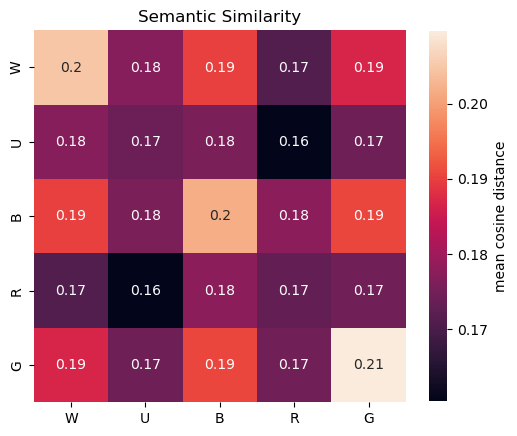

In [46]:
color_similarity_df = card_subsample.loc[:,['colors','W_mean_similarity','U_mean_similarity','B_mean_similarity','R_mean_similarity','G_mean_similarity']]
color_similarity_df['colors'] = color_similarity_df['colors'].explode()
color_similarity_df = color_similarity_df.groupby('colors').mean()
# Put back in WUBRG order:
color_similarity_df = color_similarity_df.loc[['W','U','B','R','G'],:]
# Make a heatmap
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(color_similarity_df.values, annot=True,
            xticklabels = colors,yticklabels=colors,
            square=True,cbar_kws={'shrink':0.8,'label':'mean cosine distance'})
plt.title('Semantic Similarity')
plt.show(block=False)

Overall there is very little variation in cosine similarity as a function of color. 

### Are there other aspects of a card's design that better explain its similarity in flavor to other cards? We can investigate this with clustering techniques